In [2]:
%load_ext autoreload

import sys
sys.path.append("../utils/")

# general imports
import matplotlib.pyplot as plt
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import numpy as np

import functools
import time

from quil_utils import *
from pyquil.quil import Pragma, Program
from pyquil.api import get_qc,QVM
from pyquil.gates import *
from quil_utils import Compiled_Circuit
from utils import DeviceUtils,DeviceScanner,BraketTaskScanner,Plotter,Gate_number
from braket_ez.noise_simulation import apply_aspenm2_noise
from braket_ez.scanner import dump_tasks,load_tasks,TaskScanner
from braket_ez.Ionq_compiler import IonQCompiler
from braket_ez.noise_simulation import apply_aspenm2_noise,apply_ionq11_noise

import json

In [3]:
@circuit.subroutine(register=True)
def GHZ (n_qubits):
    """
    Creates a GHZ circuit with n_qubits
    
    Parameters:
    ----------------
    n_qubits : int #of qubits
    """
    out = Circuit().h([0])
    for i in range(n_qubits-1):
        out.cnot(0,i+1)

    return out
        

In [4]:
rigetti = DeviceUtils.get_device('rigetti')
ion_q = DeviceUtils.get_device('ionq')
#rigetti = LocalSimulator()
# ion_q = LocalSimulator()

#############################
Device name:  Aspen-M-2
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2
Device provider: Rigetti
Device status: ONLINE
Device availability:  False
Device region:  us-west-1
Supported gates:  ['cz', 'xy', 'ccnot', 'cnot', 'cphaseshift', 'cphaseshift00', 'cphaseshift01', 'cphaseshift10', 'cswap', 'h', 'i', 'iswap', 'phaseshift', 'pswap', 'rx', 'ry', 'rz', 's', 'si', 'swap', 't', 'ti', 'x', 'y', 'z', 'start_verbatim_box', 'end_verbatim_box']
a:b:c:us-west-1


{'task': 0.3, 'shot': 0.00035}

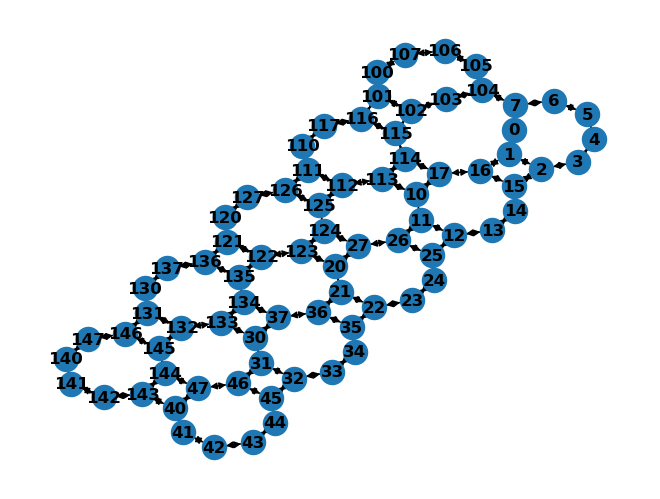

In [4]:
DeviceScanner(device=rigetti).list_properties()
DeviceScanner(device=rigetti).get_cost_infos()

#############################
Device name:  IonQ Device
Device type:  AwsDeviceType.QPU
Device arn:  arn:aws:braket:::device/qpu/ionq/ionQdevice
Device provider: IonQ
Device status: ONLINE
Device availability:  False
Device region:  
Supported gates:  ['x', 'y', 'z', 'rx', 'ry', 'rz', 'h', 'cnot', 's', 'si', 't', 'ti', 'v', 'vi', 'xx', 'yy', 'zz', 'swap']
a:b:c:us-east-1


{'task': 0.3, 'shot': 0.01}

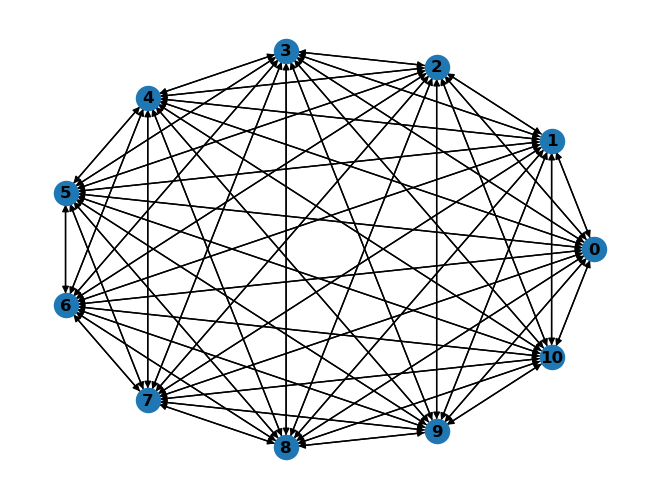

In [5]:
DeviceScanner(device=ion_q).list_properties()
DeviceScanner(device=ion_q).get_cost_infos()

## GHZ
Benchmarking QPUs with GHZ states of increasing dimensions

In [10]:
shots_ion_q = 1_000
shots_rigetti = 10_000
#set_n_qubits = range(3,10)
n_qubits_list = [2,4,6,8,10,11]

print(n_qubits_list)

[2, 4, 6, 8, 10, 11]


In [16]:
id_dict = {}
rigetti_tasks = []
ionq_tasks = []
for n_qubits in n_qubits_list:
    id_dict[str(n_qubits)] = {}
    
    circ = GHZ (n_qubits)
    #print(circ)
    rigetti_task = rigetti.run(circ,shots=shots_rigetti)
    ionq_task = ion_q.run(circ,shots=shots)
    rigetti_tasks.append(rigetti_task)
    ionq_tasks.append(ionq_task)
    
    id_dict[str(n_qubits)] = {'rigetti' : {'id' : rigetti_task.id},'ionq' : {'id' : ionq_task.id}}

In [35]:
circ = GHZ(11)
ionq_task = ion_q.run(circ,shots=1000)

In [63]:
BraketTaskScanner(qtask=ionq_task).get_status()

'COMPLETED'

In [64]:
ionq_tasks.append(ionq_task)


In [68]:
ionq_task.id

'arn:aws:braket:us-east-1:058017682654:quantum-task/090285a9-6b50-48bc-9a79-8d35b009e5b0'

In [17]:
with open('Task_files/GHZ_big_10k.json','w') as f:
    json.dump(id_dict,f,indent=3)

In [65]:
rigetti_ids = [task.id for task in rigetti_tasks]
ionq_ids = [task.id for task in ionq_tasks]


In [66]:
rigetti_task_scanners = [BraketTaskScanner(qtask=task) for task in rigetti_tasks]
ion_q_task_scanners = [BraketTaskScanner(qtask=task) for task in ionq_tasks]

In [67]:
status_rigetti = [task.get_status() for task in rigetti_task_scanners]
status_ionq = [task.get_status() for task in ion_q_task_scanners]
print(status_rigetti,status_ionq)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED'] ['COMPLETED', 'COMPLETED', 'CANCELLED', 'CANCELLED', 'CANCELLED', 'CANCELLED', 'COMPLETED']


In [29]:
results_rigetti = [qtask.get_results() for qtask in rigetti_task_scanners]
ion_q_task_objects = [qtask.get_results()for qtask in ion_q_task_scanners]

TASK RESULT ERROR: Results not available
TASK RESULT ERROR: Results not available
TASK RESULT ERROR: Results not available
TASK RESULT ERROR: Results not available


In [10]:
_,ionq_ids=load_ids('Task_files/GHZ.json')
rigetti_ids,_=load_ids('Task_files/GHZ_big_10k.json')
rigetti_task_scanners = [BraketTaskScanner(task_arn=arn) for arn in rigetti_ids]
ion_q_task_scanners = [BraketTaskScanner(task_arn=arn) for arn in ionq_ids]

In [17]:
rigetti_tasks = [scanner.get_task() for scanner in rigetti_task_scanners]
dump_tasks(rigetti_tasks,labels=n_qubits_list,filename='Task_files/GHZ_m2_10k')

ionq_tasks=[scanner.get_task() for scanner in ion_q_task_scanners]
dump_tasks(ionq_tasks,labels=n_qubits_list,filename='Task_files/GHZ_ionq_1k')


In [5]:
ionq_task_scanners = [task for task in load_tasks('Task_files/GHZ_ionq_1k').values()]
rigetti_task_scanners=[task for task in load_tasks('Task_files/GHZ_m2_10k').values()]

# RIGETTI

In [6]:
results_rigetti = [qtask.get_results() for qtask in rigetti_task_scanners]
results_ion_q = [qtask.get_results()for qtask in ionq_task_scanners]

In [7]:
# # fig, axx = plt.subplots(5, 1, figsize=(16, 30),tight_layout=True,)
# # axx = axx.reshape(-1)
# for i,n_qubits in enumerate(n_qubits_list):
#     results = results_rigetti[i]
#     Plotter.plot_binary_results(results)

In [11]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

for i,qubit_number in enumerate(n_qubits_list):
    results = results_rigetti[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
    
#     measure.append({
#             'qubit_n' : qubit_number,
#            'value': '0',
#             'counts' : zeros})
#     measure.append({'H_len' : H_len,
#             'qubit_n' : qubit_number,
#            'value': '1','counts':ones})
measure_rigetti = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_rigetti

{'qubit_n': [2, 4, 6, 8, 10, 11],
 'all_zeros': array([0.4683, 0.0963, 0.0372, 0.0191, 0.0048, 0.0033]),
 'all_ones': array([0.4112, 0.1275, 0.021 , 0.004 , 0.0015, 0.0007]),
 'other': array([0.1205, 0.7762, 0.9418, 0.9769, 0.9937, 0.996 ])}

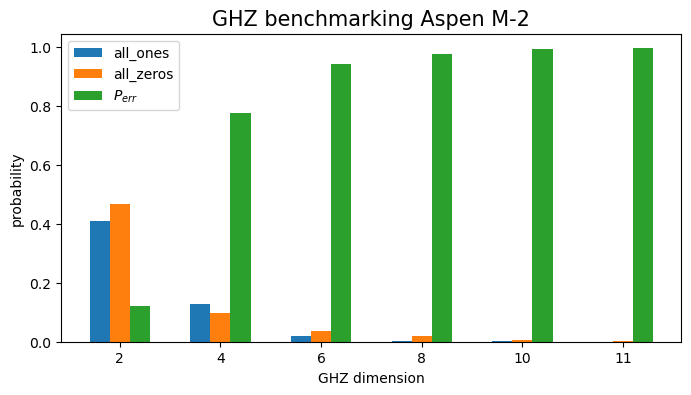

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_rigetti['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_rigetti['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_rigetti['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('GHZ benchmarking Aspen M-2',size=15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

# IONQ

In [13]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))
for i,qubit_number in enumerate(n_qubits_list):
    results = results_ion_q[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    

measure_ionq = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_ionq

{'qubit_n': [2, 4, 6, 8, 10, 11],
 'all_zeros': array([0.52 , 0.35 , 0.36 , 0.47 , 0.48 , 0.388]),
 'all_ones': array([0.47 , 0.59 , 0.42 , 0.38 , 0.25 , 0.271]),
 'other': array([0.01 , 0.06 , 0.22 , 0.15 , 0.27 , 0.341])}

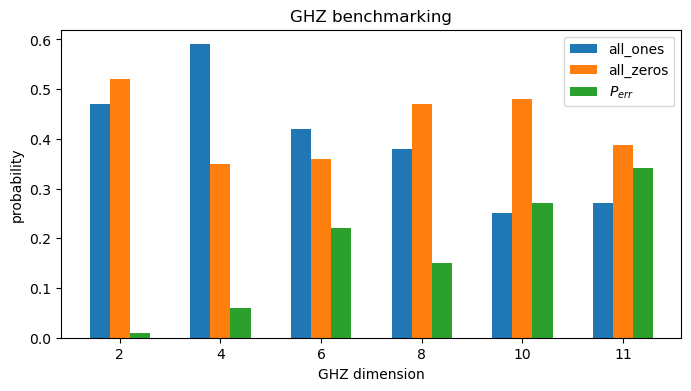

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_ionq['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_ionq['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_ionq['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(n_qubits_list)
ax.set_title('GHZ benchmarking IonQ compensated',size=20)
ax.set_title('GHZ benchmarking')
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()










# Rigetti/IonQ comparison







In [15]:
compiled_circuits_rigetti = [task.get_compiled_circuit() for task in rigetti_task_scanners]


In [16]:
N_gates_rigetti = [len([line for line in circ.splitlines() if 'MEASURE' not in line])-3 for circ in compiled_circuits_rigetti]


In [17]:
ion_q_compiler = IonQCompiler

In [18]:
compiled_circuits_ion_q = [ion_q_compiler.compile(GHZ(n_qubits)) for n_qubits in n_qubits_list]
N_gates_ion_q = [len(ion_q_compiler.compile(GHZ(n_qubits)).instructions) for n_qubits in n_qubits_list]

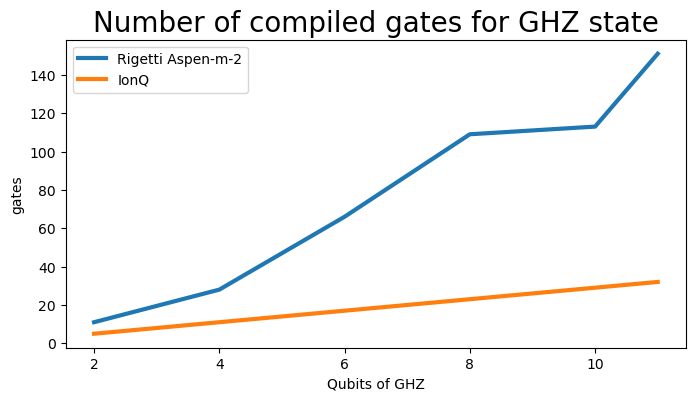

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
n_qubits_rigetti = [2,4,6,8,10,11]

ax.plot(n_qubits_rigetti,N_gates_rigetti,
       label='Rigetti Aspen-m-2',
       lw = 3)
ax.plot(n_qubits_list,N_gates_ion_q,
       label='IonQ',
       lw = 3)

ax.set_title('Number of compiled gates for GHZ state',size=20)
ax.set_xlabel('Qubits of GHZ')
ax.set_ylabel('gates')
ax.legend()

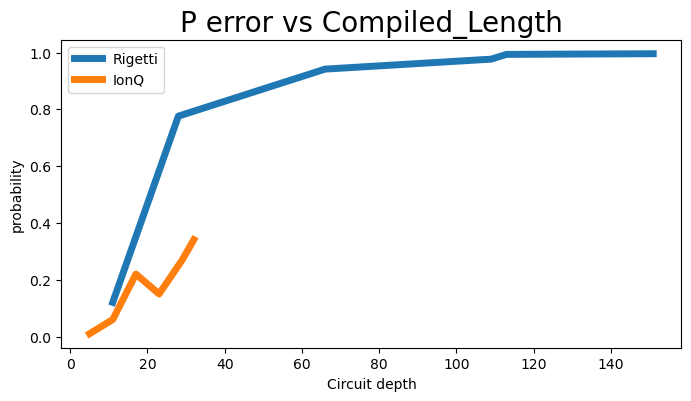

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))



ax.plot(N_gates_rigetti, measure_rigetti['other'],
            lw=5,
           label = 'Rigetti')

ax.plot(N_gates_ion_q, measure_ionq['other'],
            lw=5,
           label = 'IonQ')


ax.set_title('P error vs Compiled_Length',size=20)
ax.set_xlabel('Circuit depth')
ax.set_ylabel('probability')
ax.legend()

In [21]:
braket_circs_rigetti = [transpile_quil_to_braket(quil_circ)[0] for quil_circ in compiled_circuits_rigetti]
braket_circs_ion_q = compiled_circuits_ion_q

rigetti_entangling_gate_number = [Gate_number(circ).entangling_gates for circ in braket_circs_rigetti]
ionq_entangling_gate_number = [Gate_number(circ).entangling_gates for circ in braket_circs_ion_q]

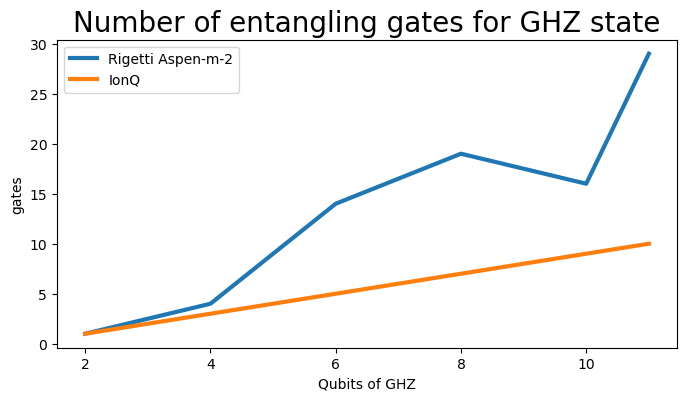

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(n_qubits_rigetti,rigetti_entangling_gate_number,
       label='Rigetti Aspen-m-2',
       lw = 3)

ax.plot(n_qubits_list,ionq_entangling_gate_number,
       label='IonQ',
       lw = 3)

ax.set_title('Number of entangling gates for GHZ state',size=20)
ax.set_xlabel('Qubits of GHZ')
ax.set_ylabel('gates')
ax.legend()

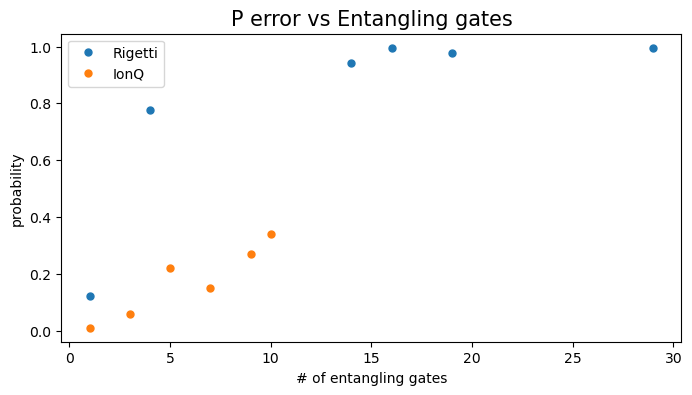

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))



ax.plot(rigetti_entangling_gate_number, measure_rigetti['other'],
            ls='',
            ms=10,
            marker='.',
           label = 'Rigetti')

ax.plot(ionq_entangling_gate_number, measure_ionq['other'],
            ls='',
            ms=10,
            marker='.',
           label = 'IonQ')


ax.set_title('P error vs Entangling gates',size=15)
ax.set_xlabel('# of entangling gates')
ax.set_ylabel('probability')
ax.legend()

# SIMULAZIONI

In [24]:
local_simulator = DeviceUtils.get_device('dm1')

## RIGETTI

In [26]:
circuits =[Quil_to_Braket_Transpiler(scanner.get_compiled_circuit(),quil_rewiring=True).braket_circ for scanner in rigetti_task_scanners]
simulation_tasks = []
labels = []
qubit_mappings_sim = []
for i,n_qubits in enumerate(n_qubits_list):
    
    circ = circuits[i]
    noisy_circ,qubit_mapping = apply_aspenm2_noise(circ)
    
    simulation_task = local_simulator.run(noisy_circ,shots=shots_rigetti)
    
    simulation_tasks.append(simulation_task)
    qubit_mappings_sim.append(qubit_mapping)
    labels.append( "ls_rigetti_ghz_s10000_#q_" + str(n_qubits))

rigetti-AspenM2
rigetti-AspenM2
rigetti-AspenM2
rigetti-AspenM2
rigetti-AspenM2
rigetti-AspenM2


In [27]:
dump_tasks(simulation_tasks, labels, filename = "Task_files/GHZ_std_rig_ls.json")

In [29]:
ls_tasks_dict = load_tasks("Task_files/GHZ_std_rig_ls.json")
ls_scanners = [task_scanner for task_scanner in ls_tasks.values()]

status = [task.get_status() for task in ls_scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [30]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

ls_results = [scanner.get_results() for scanner in ls_scanners]


for i,qubit_number in enumerate(n_qubits_list):
    results = ls_results[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_ls = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_ls

{'qubit_n': [2, 4, 6, 8, 10, 11],
 'all_zeros': array([0.4867, 0.4562, 0.279 , 0.1286, 0.1501, 0.1067]),
 'all_ones': array([0.4869, 0.4642, 0.2764, 0.1306, 0.1392, 0.1088]),
 'other': array([0.0264, 0.0796, 0.4446, 0.7408, 0.7107, 0.7845])}

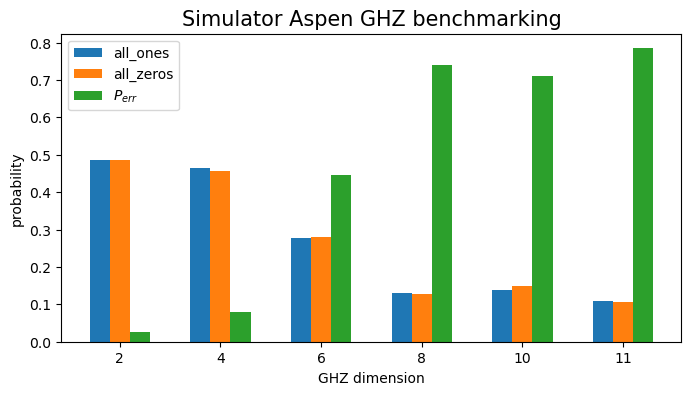

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_ls['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_ls['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_ls['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('Simulator Aspen GHZ benchmarking',size = 15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

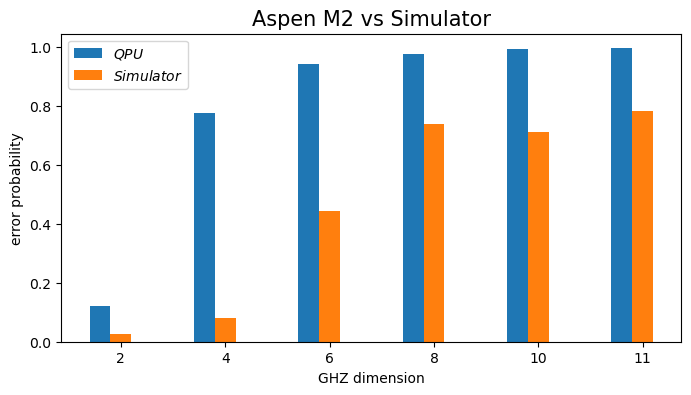

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))


ax.bar(x, measure_rigetti['other'],
            width=bar_width,
           label = '$QPU$')
ax.bar(x+bar_width, measure_ls['other'],
            width=bar_width,
           label = '$Simulator$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('Aspen M2 vs Simulator',size = 15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('error probability')
ax.legend()

## IonQ

In [40]:

simulation_tasks_ion_q = []
labels = []
for i,n_qubits in enumerate(n_qubits_list):
    
    #removing verbatim box
    circ= braket_circs_ion_q[i]
    noisy_circ = apply_ionq11_noise(circ)
    simulation_task = local_simulator.run(noisy_circ,shots=10_000)
    
    simulation_tasks_ion_q.append(simulation_task)
    labels.append( "ls_ionq_ghz_s10000_#q_" + str(n_qubits))

ionq11
0
ionq11
1
ionq11
2
ionq11
3
ionq11
4
ionq11
5


In [41]:
dump_tasks(simulation_tasks_ion_q, labels, filename = "Task_files/ionq_GHZ_l_s_std.json")

In [45]:
ls_tasks = load_tasks("Task_files/ionq_GHZ_l_s_std.json")
ls_scanners = [task_scanner for task_scanner in ls_tasks.values()]

status = [task.get_status() for task in ls_scanners]
print(status)

['COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED', 'COMPLETED']


In [46]:
all_ones = np.zeros(len(n_qubits_list))
all_zeros =np.zeros(len(n_qubits_list))
other = np.zeros(len(n_qubits_list))

ls_results = [scanner.get_results() for scanner in ls_scanners]


for i,qubit_number in enumerate(n_qubits_list):
    results = ls_results[i]
    meas_probs =results.measurement_probabilities
    all_ones[i] = meas_probs['1'*(qubit_number)] if '1'*(qubit_number) in meas_probs.keys() else 0
    all_zeros[i] = meas_probs['0'*(qubit_number)]if '0'*(qubit_number) in meas_probs.keys() else 0
    other[i] = 1 - all_ones[i] - all_zeros[i]
    
measure_ls = {
    'qubit_n' : n_qubits_list,
    'all_zeros':all_zeros,
    'all_ones':all_ones,
    'other':other
}
measure_ls

{'qubit_n': [2, 4, 6, 8, 10, 11],
 'all_zeros': array([0.45  , 0.3573, 0.2931, 0.2373, 0.2012, 0.1804]),
 'all_ones': array([0.4412, 0.3653, 0.2978, 0.2392, 0.1986, 0.1765]),
 'other': array([0.1088, 0.2774, 0.4091, 0.5235, 0.6002, 0.6431])}

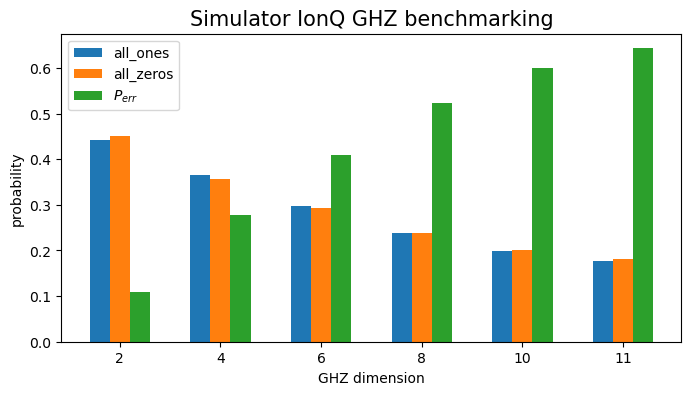

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

bar_width = .2
x = np.arange(len(n_qubits_list))

ax.bar(x, measure_ls['all_ones'],
            width=bar_width,
           label = 'all_ones')

ax.bar(x+bar_width, measure_ls['all_zeros'],
            width=bar_width,
           label = 'all_zeros')

ax.bar(x+2*bar_width, measure_ls['other'],
            width=bar_width,
           label = '$P_{err}$')


ax.set_xticks(x + bar_width )
ax.set_xticklabels(measure_rigetti['qubit_n'])
ax.set_title('Simulator IonQ GHZ benchmarking',size = 15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('probability')
ax.legend()

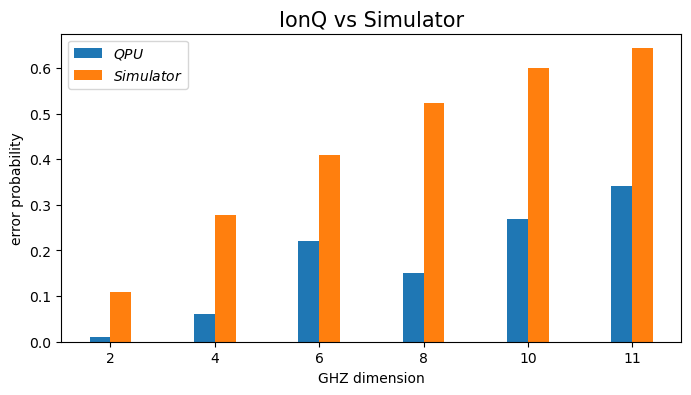

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))


bar_width = .2
x = np.arange(len(n_qubits_list))


ax.bar(x, measure_ionq['other'],
            width=bar_width,
           label = '$QPU$')
ax.bar(x+bar_width, measure_ls['other'],
            width=bar_width,
           label = '$Simulator$')


ax.set_xticks(x + bar_width/2 )
ax.set_xticklabels(measure_ionq['qubit_n'])
ax.set_title('IonQ vs Simulator',size = 15)
ax.set_xlabel('GHZ dimension')
ax.set_ylabel('error probability')
ax.legend()